In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [22]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [25]:
# Using engine to find out the data
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(0, 'USC00519397', '2010-01-01', 2.0, 18.3),
 (1, 'USC00519397', '2010-01-02', 0.0, 17.2),
 (2, 'USC00519397', '2010-01-03', 0.0, 23.3),
 (3, 'USC00519397', '2010-01-04', 0.0, 24.4),
 (4, 'USC00519397', '2010-01-06', None, 22.8)]

In [26]:
# Using inspector to find the column names
from sqlalchemy import inspect

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

Query Date:  2016-08-23


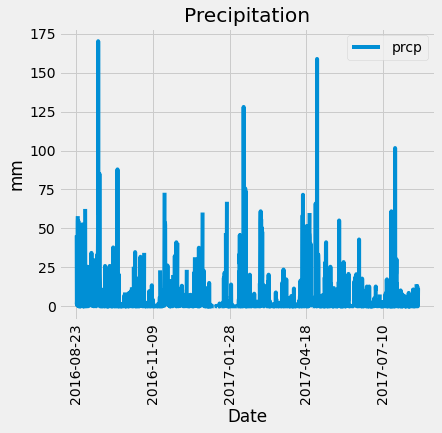

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
Query=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_query=pd.DataFrame(Query)
precipitation_query.set_index(("date"),inplace=True)
precipitation_query
# Sort the dataframe by date
sorted_prcp_data=precipitation_query.sort_values("date")
sorted_prcp_data
# Use Pandas Plotting with Matplotlib to plot the data
sorted_prcp_data.plot(figsize=(6,5), rot=90) 
plt.title("Precipitation")
plt.xlabel("Date")
plt.ylabel("mm")
plt.show()


In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_prcp_data.describe()

,prcp
count,18103.000000
mean,4.083920
std,11.905419
min,0.000000
25%,0.000000
50%,0.300000
75%,2.800000
max,292.900000


# Exploratory Station Analysis

In [39]:
# Using engine to find out the data
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(0, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.914),
 (1, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 4.45),
 (2, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 2.133),
 (3, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 3.627),
 (4, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 93.447)]

In [40]:
# Using inspector to find the column names
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [34]:
# Design a query to calculate the total number stations in the dataset
total_num_station=session.query(Station.station).count()
total_num_station

9

In [48]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = (session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station)).order_by(func.count(Measurement.id).desc()).all()
most_active 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [84]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
highest_temperature=session.query(Measurement.station,func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
highest_temperature   
lowest_temperature=session.query(Measurement.station,func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
lowest_temperature
average_temperature=session.query(Measurement.station,func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()
average_temperature

[('USC00519281', 29.4)]

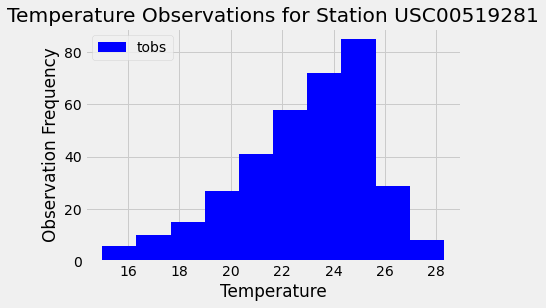

In [100]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_month_temp = session.query(Measurement.station, Measurement.tobs)\
    .filter(Measurement.date > '2016-08-23')\
    .filter(Measurement.date <= '2017-08-23')\
    .filter(Measurement.station == "USC00519281").all()
twelve_month_temp
# conveting into a Dataframe for histogram
station_temp_df = pd.DataFrame(twelve_month_temp)
station_temp_df

# plotting histogram 
station_temp_df.plot.hist(bins=10, color="b")
plt.title("Temperature Observations for Station USC00519281")
plt.xlabel("Temperature")
plt.ylabel("Observation Frequency")
plt.show()

# Close session

In [98]:
# Close Session
session.close()